In [1]:
import sys
sys.path.append("./tools")

In [2]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [5]:
%matplotlib inline

In [6]:
%%html
<style>
table {float:left;}
</style>

## Tool Modules

In [7]:
from quantum import *
from measurements import *

from unitary import *
from VQC import *

from dataSL import *
from QOLearner import *

from noise import *
from lipschitz import *

## Prepare Circuits

### - Input Circuits

In [8]:
def getOriginCircuit(bits, decode=False):
    circuit = QuantumCircuit(2, 2)
    
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.barrier(0)
    circuit.barrier(1)
    
    # encode 
    if bits[0] == '1':
        circuit.z(0)
    if bits[1] == '1':
        circuit.x(0)
    
    circuit.barrier()
    
    if decode:
        circuit.cx(0, 1)
        circuit.h(0)

    return circuit

In [9]:
# S+sx-attack at end of both
def hack(circuit):
    circuit.s(0)
    circuit.sx(1)
    
    return circuit

In [10]:
inputCircuits = []
inputHackedCircuits = []
classical_bits = ["00", "10", "01", "11"]

for bits in classical_bits:
    inputCircuits.append(getOriginCircuit(bits))
    inputHackedCircuits.append(hack(getOriginCircuit(bits)))

print(len(inputCircuits))
print(len(inputHackedCircuits))

4
4


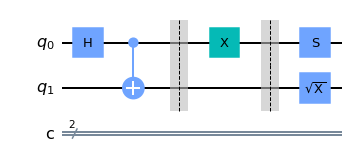

In [11]:
inputHackedCircuits[2].draw(output='mpl')

### - Output Circuits

In [13]:
def getOutputCircuit(n):
    circuit = QuantumCircuit(2 * n, 2 * n)
    
    for i in range(n):
        circuit.cx(i, i + n)
        circuit.h(i)
    
    return circuit

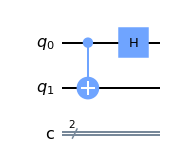

In [14]:
outputCircuit = getOutputCircuit(1)
outputCircuit.draw(output='mpl')

## Train paramters

In [17]:
import time
import sys
stdout = sys.stdout

In [18]:
# experiments times
MAX_TIMES = 10

In [19]:
class QOLearner(QOLearnerBase):
    def __init__(self, circuits, n, pos):
        super().__init__(circuits, n, pos, {}) # empty expected
        
    def cost(self, circuit, hacked_circuit, index):
        rou = getStatevector(circuit)
        sigma = getStatevector(hacked_circuit)
        loss = 0.0
        
        for i in range(len(self.measurements)):
            p = measure(self.measurements[index], rou)
            q = measure(self.measurements[index], sigma)
            
            if i != index:
                loss += p ** 2 + q ** 2
            else:
                loss += (1 - p) ** 2 + (1 - q) ** 2
                
            
        return loss / len(self.measurements) / 2
    
    def L(self, p):
        loss = 0.0
        
        for (circuit_index, circuit) in enumerate(self.circuits[0]):
            # input circuit
            circuit = circuit.copy()
            hacked_circuit = circuit.copy()
            hacked_circuit = hack(hacked_circuit)
            
            # parametered part => unitary gate / VQC
            if self.strategy == 'unitary':
                U = buildU(self.n, p)
                circuit.append(U, self.pos)
                hacked_circuit.append(U, self.pos)
            else:
                index = 0
                for layer in range(self.vqc_layers_num):
                    for i in range(self.n):
                        circuit.u2(p[index], p[index + 1], self.pos[i])
                        hacked_circuit.u2(p[index], p[index + 1], self.pos[i])
                        index += 2

                    if layer + 1 == self.vqc_layers_num:
                        break

                    for i in range(self.n):
                        if i + 1 != self.n:
                            circuit.cx(self.pos[i], self.pos[i + 1])
                            hacked_circuit.cx(self.pos[i], self.pos[i + 1])
                        elif self.n > 2:
                            circuit.cx(self.pos[i], self.pos[0])
                            hacked_circuit.cx(self.pos[i], self.pos[0])

            # remained circuit
            circuit = circuit.compose(self.circuits[1])
            hacked_circuit = hacked_circuit.compose(self.circuits[1])
            
            loss += self.cost(circuit, hacked_circuit, circuit_index)
    
        return loss

## Strategy: unitary

In [20]:
qol_unitary = QOLearner([inputCircuits, outputCircuit], 2, [0, 1])

In [21]:
times_unitary = []

for i in range(MAX_TIMES):
    sys.stdout = None
    start = time.clock()
    qol_unitary.fit(epoch=1000, strategy='unitary', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_unitary.append(end - start)
    sys.stdout = stdout
    
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_unitary.params[-1], 'ssxAttack', 'unitary', i + 1)
    saveLosses(qol_unitary.losses, 'ssxAttack', 'unitary', i + 1)

Fin - No. 1
Fin - No. 2
Fin - No. 3
Fin - No. 4
Fin - No. 5
Fin - No. 6
Fin - No. 7
Fin - No. 8
Fin - No. 9
Fin - No. 10


In [22]:
print(f'Average times for unitary: {np.mean(times_unitary)}')

Average times for unitary: 63.15426408


### - plot a loss example

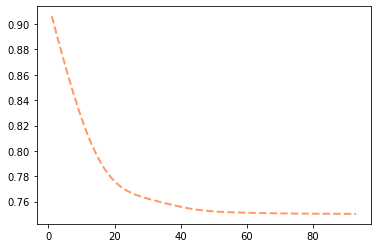

In [23]:
plot(loadLosses('ssxAttack', 'unitary', 3), color=palette['unitary'])

In [24]:
losses_unitary= []
max_length = 0
for i in range(MAX_TIMES):
    losses_unitary.append(loadLosses('ssxAttack', 'unitary', i + 1))
    max_length = max(max_length, len(losses_unitary[-1]))

for i in range(MAX_TIMES):
    length = len(losses_unitary[i])
    while length < max_length:
        losses_unitary[i].append(losses_unitary[i][-1])
        length += 1

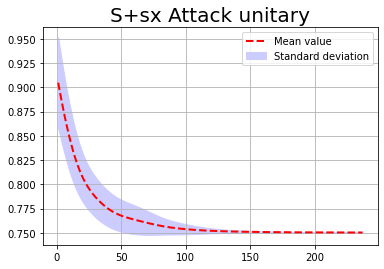

In [25]:
plotLosses(losses_unitary, title='S+sx Attack unitary')

### - average time and loss

In [38]:
average_loss_unitary = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('ssxAttack', 'unitary', i + 1)[-1]
    average_loss_unitary += loss
print(f'Average loss for unitary: {average_loss_unitary / MAX_TIMES}')

Average loss for unitary: (0.7503384985756516+0j)


In [39]:
average_epoch_unitary = 0
for i in range(MAX_TIMES):
    loss = loadLosses('ssxAttack', 'unitary', i + 1)
    average_epoch_unitary += len(loss)
print(f'Average epoch for unitary: {average_epoch_unitary / MAX_TIMES}')

Average epoch for unitary: 149.1


In [40]:
average_time_unitary = 63.15426408

In [41]:
average_time_per_epoch_unitary = average_time_unitary / average_epoch_unitary
print(f'Average time per epoch for unitary: {average_time_per_epoch_unitary}')

Average time per epoch for unitary: 0.042356984627766596


|Strategy| parameterized unitary |
|:----------------:|:-----:|
| Average loss | 0.75034 |
| Average time | 63.15 |
| Average epochs | 149.1 |
| Average time per epoch | 0.04236 |

## Strategy: VQC

In [26]:
qol_vqc = QOLearner([inputCircuits, outputCircuit], 2, [0, 1])

In [27]:
times_vqc = []

for i in range(MAX_TIMES):
    sys.stdout = None
    start = time.clock()
    qol_vqc.fit(epoch=1000, strategy='vqc', stepsize=0.005, early_stopping=True)
    end = time.clock()
    times_vqc.append(end - start)
    sys.stdout = stdout
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_vqc.params[-1], 'ssxAttack', 'vqc', i + 1)
    saveLosses(qol_vqc.losses, 'ssxAttack', 'vqc', i + 1)

Fin - No. 1
Fin - No. 2
Fin - No. 3
Fin - No. 4
Fin - No. 5
Fin - No. 6
Fin - No. 7
Fin - No. 8
Fin - No. 9
Fin - No. 10


In [28]:
print(f'Average times for vqc: {np.mean(times_vqc)}')

Average times for vqc: 79.01109691


### - plot a loss example

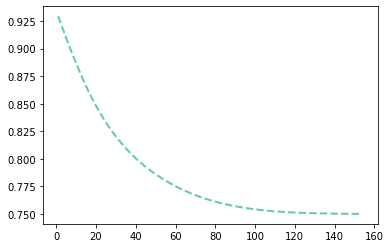

In [29]:
plot(loadLosses('ssxAttack', 'vqc', 1), color=palette['vqc'])

In [30]:
losses_vqc= []
max_length = 0
for i in range(10):
    losses_vqc.append(loadLosses('ssxAttack', 'vqc', i + 1))
    max_length = max(max_length, len(losses_vqc[-1]))

for i in range(10):
    length = len(losses_vqc[i])
    while length < max_length:
        losses_vqc[i].append(losses_vqc[i][-1])
        length += 1

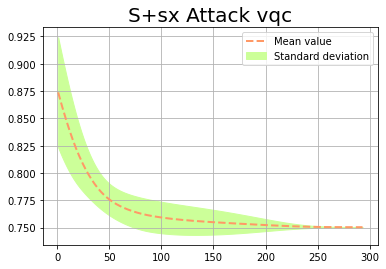

In [31]:
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="S+sx Attack vqc")

### - average time and loss

In [44]:
average_loss_vqc = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('ssxAttack', 'vqc', i + 1)[-1]
    average_loss_vqc += loss
print(f'Average loss for vqc: {average_loss_vqc / MAX_TIMES}')

Average loss for vqc: (0.7503677562287169+0j)


In [45]:
average_epoch_vqc = 0
for i in range(MAX_TIMES):
    loss = loadLosses('ssxAttack', 'vqc', i + 1)
    average_epoch_vqc += len(loss)
print(f'Average epoch for vqc: {average_epoch_vqc / MAX_TIMES}')

Average epoch for vqc: 188.2


In [46]:
average_time_vqc = 79.01109691

In [47]:
average_time_per_epoch_vqc = average_time_vqc / average_epoch_vqc
print(f'Average time per epoch for vqc: {average_time_per_epoch_vqc}')

Average time per epoch for vqc: 0.04198251695536664


| Strategy | VQC |
|:----------------:|:-----:|
| Average loss | 0.7504 |
| Average time | 79.01 |
| Average epochs | 188.2 |
| Average time per epoch | 0.04198 |

##  Summarize

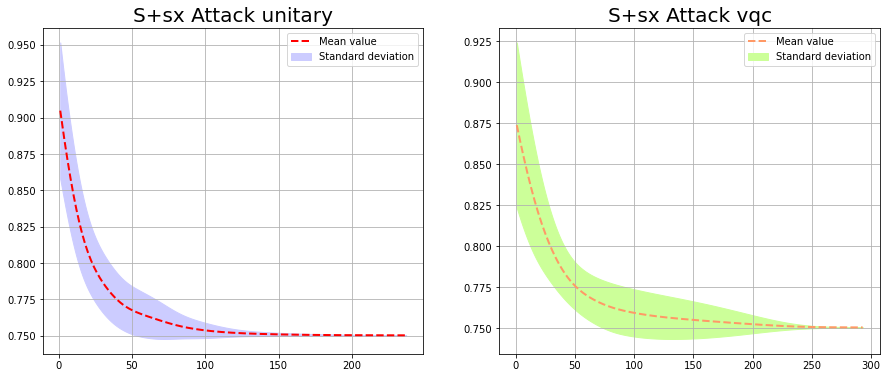

In [48]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plotLosses(losses_unitary, title="S+sx Attack unitary")
plt.subplot(1,2,2)
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="S+sx Attack vqc")

## Compare Lipschitz

In [33]:
measurements = getMeasurements(2)

In [34]:
names = ['unitary', 'vqc']

In [35]:
error_params = [
    [0.1 , 'b'], [0.1 , 'p'], [0.1 , 'd'], 
    [0.01 , 'b'], [0.01 , 'p'], [0.01 , 'd'], 
    [0.001 , 'b'], [0.001 , 'p'], [0.001 , 'd'], 
    [0.0001 , 'b'], [0.0001 , 'p'], [0.0001 , 'd'], 
]

### - exact Lipschitz

In [37]:
smallestDict = { k: 0 for k in names }

for (p, errorType) in error_params:
    print(f' - p = {p}, errorType: {errorType}')
    
    # simulate noise input circuits
    noiseInputCircuits = getNoiseCircuits(inputCircuits + inputHackedCircuits, p, errorType)

    smallest = 1.0; smallestKey = ''
    for name in names: # unitary or vqc
        lip = 0.0
        
        for i in range(MAX_TIMES):
            # build targetCircuit
            params = loadParams('ssxAttack', name, i + 1)
            targetCircuit = QuantumCircuit(2, 2)
            
            if name == 'unitary':
                targetCircuit.append(buildU(2, params), [0, 1])
            else:
                targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])
                
            lip += calculateExactLipschitz(
                inputCircuits + inputHackedCircuits, noiseInputCircuits, 
                targetCircuit, outputCircuit, measurements
            )
        lip = lip / MAX_TIMES
        
        if lip < smallest:
            smallest = lip
            smallestKey = name
        
        print(f'Lipschitz for [{name}] is: {lip}\n')
    
    smallestDict[smallestKey]  += 1.0
    print(f'smallest one: [{smallestKey}]')
        
    print('-' * 25)
    print()

print(smallestDict)

 - p = 0.1, errorType: b
Lipschitz for [unitary] is: 0.06810855105177781

Lipschitz for [vqc] is: 0.01108131252600814

smallest one: [vqc]
-------------------------

 - p = 0.1, errorType: p
Lipschitz for [unitary] is: 0.057813865215310255

Lipschitz for [vqc] is: 0.015737850085071357

smallest one: [vqc]
-------------------------

 - p = 0.1, errorType: d
Lipschitz for [unitary] is: 0.05930327241831272

Lipschitz for [vqc] is: 0.013736627349252389

smallest one: [vqc]
-------------------------

 - p = 0.01, errorType: b
Lipschitz for [unitary] is: 0.06810855102944659

Lipschitz for [vqc] is: 0.01108131250638118

smallest one: [vqc]
-------------------------

 - p = 0.01, errorType: p
Lipschitz for [unitary] is: 0.05781386519610152

Lipschitz for [vqc] is: 0.0157378500923363

smallest one: [vqc]
-------------------------

 - p = 0.01, errorType: d
Lipschitz for [unitary] is: 0.05926547664926483

Lipschitz for [vqc] is: 0.01373885415364252

smallest one: [vqc]
-------------------------


### - approximate Lipschitz

In [36]:
for name in names: # unitary or vqc
    lip = 0.0

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('ssxAttack', name, i + 1)
        targetCircuit = QuantumCircuit(2, 2)

        if name == 'unitary':
            targetCircuit.append(buildU(2, params), [0, 1])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 2, params, [0, 1])

        lip += calculateLipschitz(targetCircuit, outputCircuit, measurements)
                                  
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}\n')

Lipschitz for [unitary] is: 0.029017037551985037

Lipschitz for [vqc] is: 0.0016940049974183558



In [15]:
unitary_params = loadParams('ssxAttack', 'unitary', 1)
vqc_params = loadParams('ssxAttack', 'vqc', 1)

In [16]:
def statisticCount(counts):
    dictionary = {'00': 0, '01': 0, '10': 0, '11': 0}

    for key in counts:
        # dict[key[:2]]
        dictionary[ key[:2] ] += counts[key]

    print(f'1: {dictionary}')

In [17]:
def stat(circuit, shots=1000):
    circuit = circuit.copy()
    circuit.measure([0, 1], [1, 0])
    
    job = execute(circuit, simulator, shots = shots)
    results = job.result()
    counts = results.get_counts(circuit)
    
    print(counts)
    print()
    statisticCount(counts)

In [18]:
def initVQCFullCircuit(bits, params, hack=False):
    circuit = getOriginCircuit(bits, decode=False)
    if hack:
        circuit.s(0)
        circuit.sx(1)
        circuit.barrier()

    circuit.u2(params[0],params[1], 0)
    circuit.u2(params[2],params[3], 1)
    circuit.cx(0, 1)
    circuit.u2(params[4],params[5], 0)
    circuit.u2(params[6],params[7], 1)
    circuit.cx(0, 1)
    circuit.u2(params[8],params[9], 0)
    circuit.u2(params[10],params[11], 1)
    
    circuit.barrier()

    circuit.cx(0, 1)
    circuit.h(0)

    return circuit

In [19]:
bits = "11"

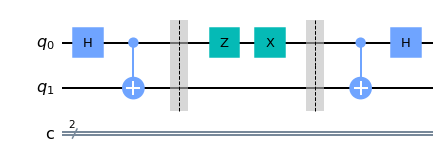

In [24]:
origin_circuit = getOriginCircuit(bits, True)
origin_circuit.draw(output='mpl')

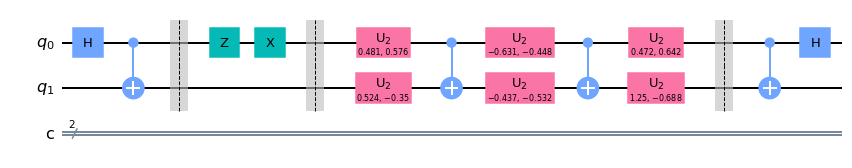

In [21]:
vqc_circuit = initVQCFullCircuit(bits, vqc_params)
vqc_circuit.draw(output='mpl')

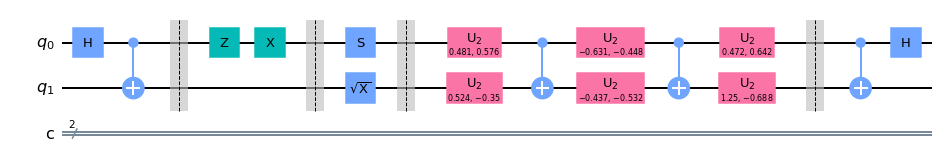

In [22]:
vqc_circuit_hacked = initVQCFullCircuit(bits, vqc_params, True)
vqc_circuit_hacked.draw(output='mpl')

In [26]:
classical_bits = ["00", "10", "01", "11"]

for bits in classical_bits:
    print(f'Testing: {bits}\n')
    origin_circuit = getOriginCircuit(bits, True)
    vqc_circuit = initVQCFullCircuit(bits, vqc_params)
    vqc_circuit_hacked = initVQCFullCircuit(bits, vqc_params, True)

    stat(origin_circuit, shots=1000)
    print('\n' + '-' * 60 + '\n')
    stat(vqc_circuit, shots=1000)
    print('\n' + '-' * 60 + '\n')
    stat(vqc_circuit_hacked, shots=1000)
    print('\n\n')

Testing: 00

{'00': 1000}

1: {'00': 1000, '01': 0, '10': 0, '11': 0}

------------------------------------------------------------

{'10': 249, '11': 289, '01': 208, '00': 254}

1: {'00': 254, '01': 208, '10': 249, '11': 289}

------------------------------------------------------------

{'10': 313, '01': 236, '00': 253, '11': 198}

1: {'00': 253, '01': 236, '10': 313, '11': 198}



Testing: 10

{'10': 1000}

1: {'00': 0, '01': 0, '10': 1000, '11': 0}

------------------------------------------------------------

{'10': 238, '00': 263, '11': 239, '01': 260}

1: {'00': 263, '01': 260, '10': 238, '11': 239}

------------------------------------------------------------

{'11': 261, '00': 273, '01': 202, '10': 264}

1: {'00': 273, '01': 202, '10': 264, '11': 261}



Testing: 01

{'01': 1000}

1: {'00': 0, '01': 1000, '10': 0, '11': 0}

------------------------------------------------------------

{'00': 270, '11': 250, '01': 264, '10': 216}

1: {'00': 270, '01': 264, '10': 216, '11': 250}